## NZ News coverage over time

Prior assumption: it makes sense to aggregate news by week as newsroom probably operate on a weekly release schedule.

In [50]:
import os
import re
from datetime import datetime, timedelta
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [10.0, 6.0]

In [3]:
%%time
# Import all files - sorting the files should ensure that the Datetime column is ordered correctly
processed_folder = "processed_ccnews"
all_files = [os.path.join(processed_folder, file) for file in os.listdir(processed_folder) if file != ".ipynb_checkpoints"]
articles = pd.concat((pd.read_csv(f) for f in sorted(all_files)), ignore_index=True)

articles['Datetime'] = pd.to_datetime(articles['Datetime'], format="%Y-%m-%dT%H:%M:%SZ")
print(f"Start datetime: {articles['Datetime'].iloc[0]}\n"
      f"End datetime:   {articles['Datetime'].iloc[-1]}")

Start datetime: 2020-01-01 02:47:58
End datetime:   2021-03-07 00:39:33
CPU times: user 1.78 s, sys: 378 ms, total: 2.16 s
Wall time: 2.16 s


In [4]:
%%time
articles['Words'] = [re.findall(r"[\w']+", text_i) for text_i in articles['Text']]

CPU times: user 3.82 s, sys: 309 ms, total: 4.13 s
Wall time: 4.13 s


In [5]:
articles.head()

,Datetime,URL,Text,Words
0,2020-01-01 02:47:58,https://www.nzherald.co.nz/world/news/article....,The Senate isn't the only place where Donald T...,"[The, Senate, isn't, the, only, place, where, ..."
1,2020-01-01 02:48:04,https://www.nzherald.co.nz/world/news/article....,One of the thorniest challenges of this moment...,"[One, of, the, thorniest, challenges, of, this..."
2,2020-01-01 03:17:03,https://www.nzherald.co.nz/nz/news/article.cfm...,Your news how you want it.\n\nOn the go and no...,"[Your, news, how, you, want, it, On, the, go, ..."
3,2020-01-01 03:17:09,https://www.nzherald.co.nz/nz/news/article.cfm...,A petition to keep child rapist Raurangi Mark ...,"[A, petition, to, keep, child, rapist, Raurang..."
4,2020-01-01 03:17:15,https://www.nzherald.co.nz/nz/news/article.cfm...,By Karoline Tuckey of RNZ\n\nProtesters at a N...,"[By, Karoline, Tuckey, of, RNZ, Protesters, at..."


In [6]:
articles.resample('W-Mon', on='Datetime').count()

,Datetime,URL,Text,Words
Datetime,,,,
2020-01-06,2846,2846,2846,2846
2020-01-13,4701,4701,4701,4701
2020-01-20,5019,5019,5019,5019
2020-01-27,4897,4897,4897,4897
2020-02-03,5365,5365,5365,5365
...,...,...,...,...
2021-02-08,0,0,0,0
2021-02-15,0,0,0,0
2021-02-22,0,0,0,0


In [7]:
daily = pd.DataFrame(articles.resample('D', on='Datetime').count()['Datetime'])
daily.columns = ['Count']
daily['Day'] = daily.index.day_name().astype("category").reorder_categories(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
daily.head(15)

,Count,Day
Datetime,,
2020-01-01,332,Wednesday
2020-01-02,373,Thursday
2020-01-03,516,Friday
2020-01-04,492,Saturday
2020-01-05,466,Sunday
2020-01-06,667,Monday
2020-01-07,764,Tuesday
2020-01-08,766,Wednesday
2020-01-09,627,Thursday


In [8]:
daily['Month'] = daily.index.month_name().str.slice(stop=3)
daily['Day_no'] = daily.index.day
daily.head(15)

,Count,Day,Month,Day_no
Datetime,,,,
2020-01-01,332,Wednesday,Jan,1
2020-01-02,373,Thursday,Jan,2
2020-01-03,516,Friday,Jan,3
2020-01-04,492,Saturday,Jan,4
2020-01-05,466,Sunday,Jan,5
2020-01-06,667,Monday,Jan,6
2020-01-07,764,Tuesday,Jan,7
2020-01-08,766,Wednesday,Jan,8
2020-01-09,627,Thursday,Jan,9


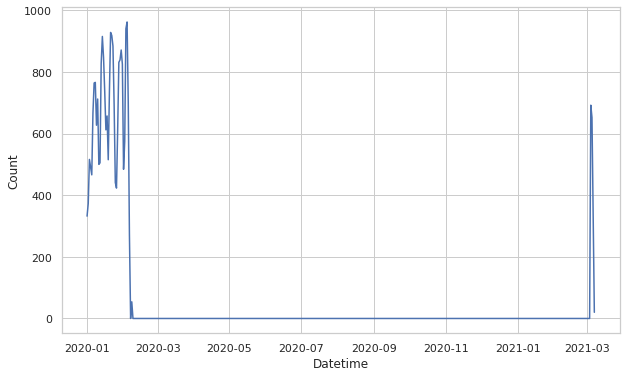

In [9]:
plt.figure(figsize=(10,6))
sns.lineplot(data=daily, x="Datetime", y="Count");

In [10]:
daily_non_zero = daily[daily['Count'] != 0]

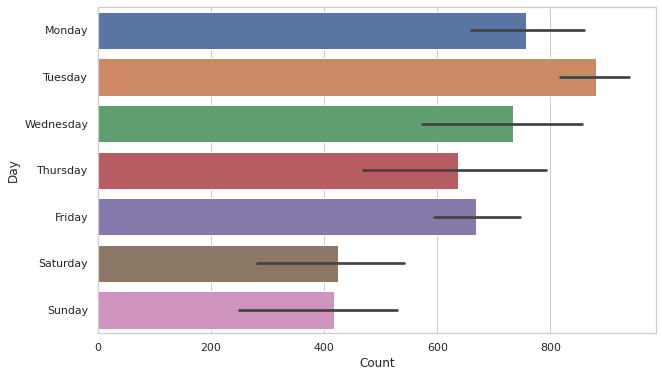

In [11]:
plt.figure(figsize=(10,6))
sns.barplot(data=daily_non_zero, x="Count", y="Day");

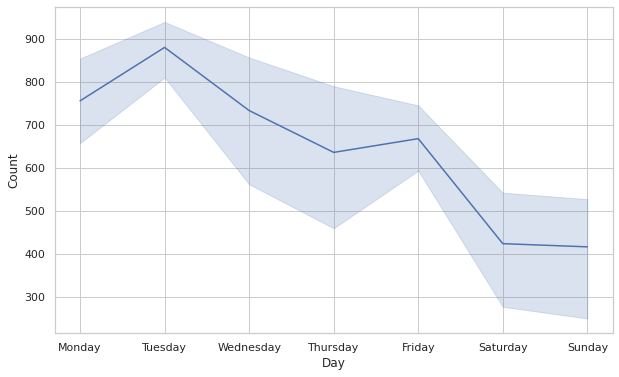

In [12]:
plt.figure(figsize=(10,6))
sns.lineplot(data=daily_non_zero, x="Day", y="Count");

## Trend estimation

- Trends
- Seasonality
- Irregularity
- Cyclic

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

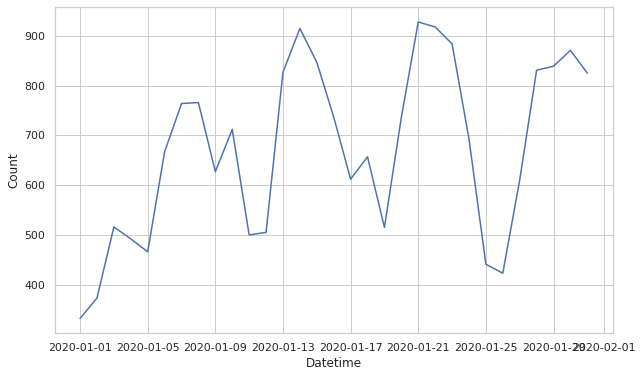

In [14]:
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 1, 31)

daily_jan = daily[start_date : end_date]
g = sns.lineplot(data=daily_jan, x="Datetime", y="Count", markers={'2021-01-01': 'Jan'})
# g.set_xticklabels(rotation=45)
g;

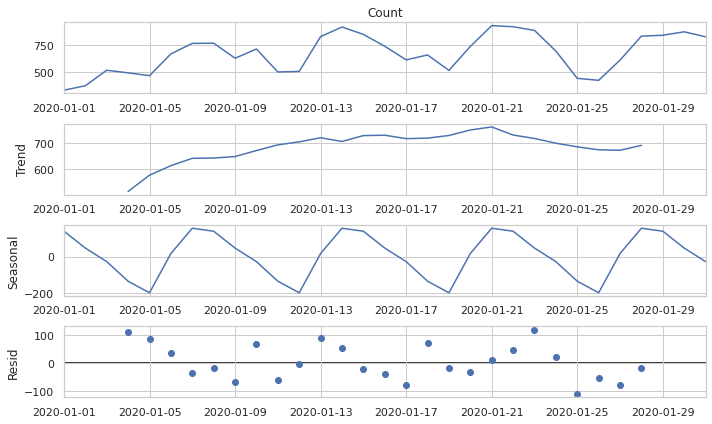

In [15]:
res = seasonal_decompose(daily_jan['Count'], model='additive')
x = res.plot()

Number of Articles (Trend)


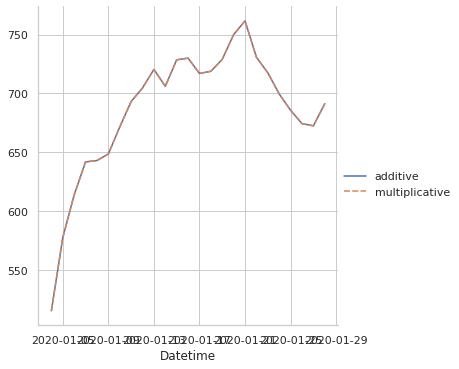

In [35]:
seasonals = pd.concat({
    'additive': seasonal_decompose(daily_jan['Count'], model='additive').trend, 
    'multiplicative': seasonal_decompose(daily_jan['Count'], model='multiplicative').trend
}, axis=1)

print("Number of Articles (Trend)")
sns.relplot(data=seasonals, kind="line");

Datetime
2020-01-06     17.234694
2020-01-07    155.698980
2020-01-08    139.341837
2020-01-09     47.056122
2020-01-10    -27.229592
2020-01-11   -134.372449
2020-01-12   -197.729592
Freq: D, Name: seasonal, dtype: float64


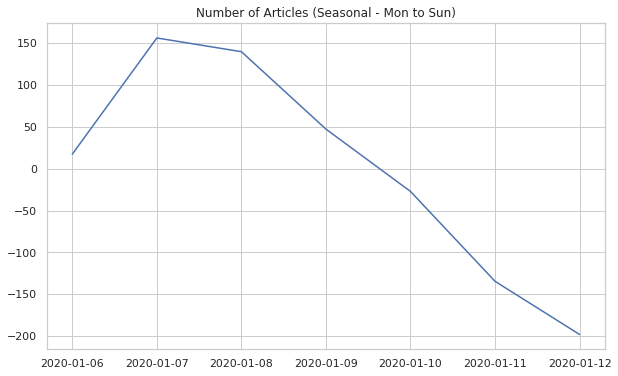

In [67]:
# sns.lineplot(data=res.seasonal)
first_monday = daily[daily['Day'] == "Monday"].index[0]
seasonal_week = res.seasonal[first_monday:(first_monday + timedelta(days=6))]
print(seasonal_week)
fig, ax = plt.subplots()
ax.plot(seasonal_week)
ax.set(title="Number of Articles (Seasonal - Mon to Sun)");